In [1]:
import numpy as np
import os
from matplotlib import pyplot
from matplotlib import ticker
from open_atmos_jupyter_utils import show_plot
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity

from PySDM import Formulae
from PySDM.physics import si
from PySDM.products import (
    ParcelDisplacement,
    AmbientRelativeHumidity,
    ActivatedParticleConcentration,
    MeanVolumeRadius,
    AreaStandardDeviation,
    CollisionRatePerGridbox
)

TRIVIA = Formulae().trivia

from PySDM_examples.Collisions import Settings, Simulation

In [2]:
products=(
    ParcelDisplacement(
        name='z'),
    AmbientRelativeHumidity(
        name='S_max', unit='%', var='RH'),
    ActivatedParticleConcentration(
        name= 'n_act',count_activated=True,count_unactivated=False,stp=True),
    MeanVolumeRadius(
        name= 'r_vol', count_activated=True,count_unactivated=False),
    AreaStandardDeviation(
        name='area_std', count_activated=True,count_unactivated=False),
    #CollisionRatePerGridbox(name="collision_rate"),
)

vertical_velocity=1*si.m/si.s
output = {
    case: Simulation(Settings(
        dt=1*si.s,
        vertical_velocity=vertical_velocity,
        n_sd=64,
        aerosol=case
    ), sampling_class=ConstantMultiplicity, products=products).run()
    for case in ("pristine", "polluted")
}


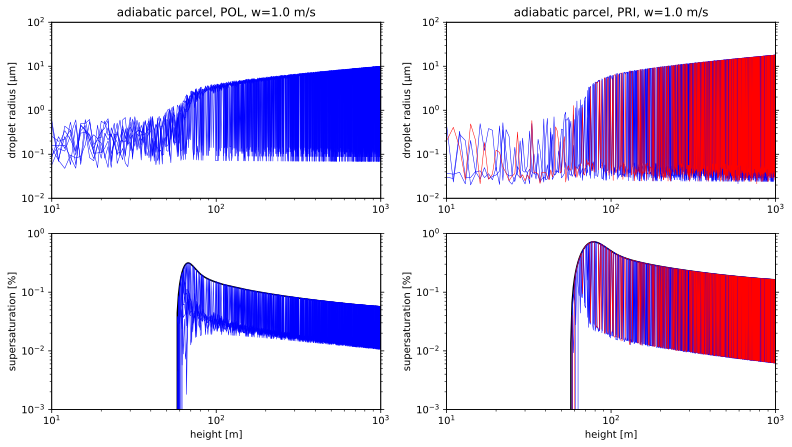

HTML(value="<a href='./tmpm3bxr76x.pdf' target='_blank'>./tmpm3bxr76x.pdf</a><br>")

In [3]:
# pylint: disable=too-many-arguments
def plot_R(ax,output_vol,output_crit_vol,output_z,k):
    for drop_id, volume in enumerate(output_vol):
        if drop_id%k==0:
            if TRIVIA.radius(volume=volume)[10]>0.03*si.um:
                crit_volume=output_crit_vol[drop_id]
                if np.all(volume<crit_volume):
                    ax.plot(
                        output_z,
                        TRIVIA.radius(volume=volume) / si.um,
                        linewidth=0.5,
                        color='green'
                    )
                elif volume[-1]<crit_volume[-1]:
                    ax.plot(
                        output_z,
                        TRIVIA.radius(volume=volume)/ si.um,
                        linewidth=0.5,
                        color='red'
                    )       
                else:
                    ax.plot(
                        output_z,
                        TRIVIA.radius(volume=volume) / si.um,
                        linewidth=0.5,
                        color='blue'
                    )

def plot_S(ax,output_Seq,output_vol,output_crit_vol,output_z,k):
    for drop_id, S_eq in enumerate(output_Seq):
        if drop_id%k==0:
            volume=output_vol[drop_id]
            crit_volume=output_crit_vol[drop_id]
            if TRIVIA.radius(volume=volume[10])>0.03*si.um:
                if np.all(volume<crit_volume):
                    ax.plot(
                        output_z,
                        (S_eq-1)*100,        
                        color='green')
                elif volume[-1]<crit_volume[-1]:
                    ax.plot(
                        output_z,
                        (S_eq-1)*100,
                        linewidth=0.5,
                        color='red')   
                else:
                    ax.plot(
                        output_z,
                        (S_eq-1)*100,
                        linewidth=0.5,
                        color='blue')              
                    

fig, axs = pyplot.subplots(2, 2, figsize=(13, 7))
axS1, axS2, axR1, axR2 = [axs[1,0], axs[1,1], axs[0,0], axs[0,1]]

for aerosol, i in (("polluted",0),("pristine",1)):
    axs[1,i].plot(output[aerosol]['products']['z'],np.asarray(output[aerosol]['products']['S_max'])-100, color='black')
    plot_S(axs[1,i],np.asarray(output[aerosol]['attributes']['equilibrium supersaturation']),np.asarray(output[aerosol]['attributes']['volume']),np.asarray(output[aerosol]['attributes']['critical volume']),np.asarray(output[aerosol]['products']['z']),8)
    plot_R(axs[0,i],np.asarray(output[aerosol]['attributes']['volume']),np.asarray(output[aerosol]['attributes']['critical volume']),np.asarray(output[aerosol]['products']['z']),8)

axS1_, axS2_, axR1_, axR2_ = [axS1.twinx(),axS2.twinx(),axR1.twinx(),axR2.twinx()]
for ax in [axS1, axS1_, axS2, axS2_, axR1, axR1_, axR2, axR2_]:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10, 1000)
for ax in [axS1,axS1_,axS2,axS2_]:
    ax.set_ylim(0.001, 1)
for ax in [axR1,axR1_,axR2,axR2_]:
    ax.set_ylim(0.01, 100)
for ax in [axR1,axR2]:
    ax.set_ylabel('droplet radius [μm]')
axR1.set_title(f'adiabatic parcel, POL, w={vertical_velocity} m/s')
axR2.set_title(f'adiabatic parcel, PRI, w={vertical_velocity} m/s')
for ax in [axS1,axS2]:
    ax.set_xlabel('height [m]')
    ax.set_ylabel('supersaturation [%]') 
for ax in [axS1_,axS2_,axR1_,axR2_]:
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
show_plot()

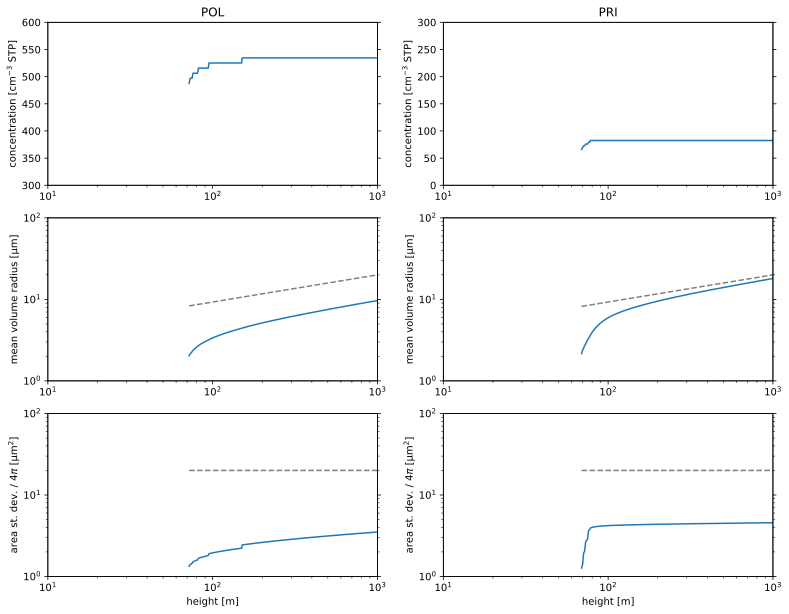

In [4]:
fig, axs = pyplot.subplots(3, 2, figsize=(13, 10))
axN1,axN2,axR1,axR2,axA1,axA2 = [axs[0,0], axs[0,1], axs[1,0], axs[1,1], axs[2,0], axs[2,1]]

for aerosol, i in (("polluted",0),("pristine",1)):
    for w in (vertical_velocity,):
        r=np.array(output[aerosol]['products']['r_vol'])
        n=np.array(output[aerosol]['products']['n_act'])
        a=np.array(output[aerosol]['products']['area_std'])/(4*np.pi)
        axs[1,i].plot(np.array(output[aerosol]['products']['z']),np.where(r*10**6>2,r*10**6,np.nan))
        axs[0,i].plot(np.array(output[aerosol]['products']['z']),np.where(r*10**6>2,n*10**(-6),np.nan))
        axs[2,i].plot(np.array(output[aerosol]['products']['z']),np.where(r*10**6>2,a*10**12,np.nan))
    axs[1,i].plot(np.array(output[aerosol]['products']['z']),np.where(r*10**6>2,2*np.array(output[aerosol]['products']['z'])**(1/3),np.nan),color='grey',linestyle='--')
    axs[2,i].plot(np.array(output[aerosol]['products']['z']),np.where(r*10**6>2,20,np.nan),color='grey',linestyle='--')

for ax in [axN1,axN2,axR1,axR2,axA1,axA2]:
    ax.set_xlim(10,1000)
    ax.set_xscale('log')
    #ax.legend(legend)
for ax in [axR1,axR2]:
    ax.set_ylabel('mean volume radius [μm]')
for ax in [axN1,axN2]:
    ax.set_ylabel('concentration [cm$^{-3}$ STP]')
for ax in [axA1,axA2]:
    ax.set_xlabel('height [m]')
    ax.set_ylabel(r'area st. dev. / 4$\pi$ [μm$^2$]')
    
axN1_, axN2_, axR1_, axR2_, axA1_, axA2_ = [axN1.twinx(),axN2.twinx(),axR1.twinx(),axR2.twinx(),axA1.twinx(),axA2.twinx()]
for ax in [axR1,axR2,axR1_,axR2_,axA1,axA2,axA1_,axA2_]:
    ax.set_yscale('log')
    ax.set_ylim(1,100)
for ax in [axN1,axN1_]:
    ax.set_ylim(300,600)
for ax in [axN2,axN2_]:
    ax.set_ylim(0,300)
axN1.set_title('POL')
axN2.set_title('PRI')
for ax in [axN1_,axN2_,axR1_,axR2_,axA1_,axA2_]:
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
pyplot.show()